In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [ ]:
import os
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import pickle
import base64
import re

In [ ]:
#### Edit variables and filepaths here ####
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
DATASET_SEED = 2
BASE = 'base' # embedding size 'base' or 'large'
EMBEDDING = 'wav2vec_embeddings' # 'hubert_embeddings' or 'wav2vec_embeddings'
LARGE_LSTM = False # size of LSTM model, large or small
SAVE_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/lstm-base/model.pth')
SAVE_PLOT_IMG_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/lstm-base/epoch_loss.png')
SEED = 42
torch.manual_seed(SEED)

In [ ]:
train_csv_file = os.path.join(DATASET_FILEPATH, f'{BASE}/{DATASET_SEED}/processed/train_dataset.csv')
validation_csv_file = os.path.join(DATASET_FILEPATH, f'{BASE}/{DATASET_SEED}/processed/validation_dataset.csv')
aug_train_csv_file = os.path.join(DATASET_FILEPATH, f'{BASE}/aug-dataset/processed/train_dataset.csv')

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

Device:  cuda


In [ ]:
# serialization helper functions
def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

selected_columns = ['audio_file_name','classification', EMBEDDING]
train_df = pd.read_csv(train_csv_file, usecols=selected_columns, converters={EMBEDDING : to_tensor})
validation_df = pd.read_csv(validation_csv_file, usecols=selected_columns, converters={EMBEDDING : to_tensor})
print('CSV presaved and loaded in')

CSV presaved and loaded in


In [ ]:
def process_training_set(train_df, oversample_minority=False, undersample_majority=False):
  """
  Re-sample the training dataset, with options to oversample minority class and undersample majority class based on audio lengths.

  :param train_df: DataFrame containing the training data with columns ['classification', 'audio_file_name'] among others.
  :param oversample_minority: Boolean, if True, the minority class (classification == 0) is duplicated to balance the dataset.
  :param undersample_majority: Boolean, if True, majority class data with audio lengths above a threshold (specified by DROP_SEGMENTS) are dropped.
  :returns: DataFrame with the desired processed training data.
  """
  if oversample_minority:
    class_0 = train_df[train_df['classification'] == 0]
    train_df = pd.concat([train_df, class_0])
  if undersample_majority:
    DROP_SEGMENTS = 5
    def get_audio_length_group(file_name):
        return int(re.findall(r'\d+', file_name)[-1])
    train_df['audio_length_group'] = train_df['audio_file_name'].apply(get_audio_length_group)
    train_df = train_df[train_df['audio_length_group'] <= DROP_SEGMENTS]
    train_df = train_df.drop(columns=['audio_length_group'])

  # some indices are duplicated / removed so we have to reset them
  train_df.reset_index(drop=True, inplace=True)
  return train_df

def print_dataset_balance(df):
    """
    Prints the balance of classifications in a given dataset.

    :param df: DataFrame containing the data with a 'classification' column.
    """
    classification_counts = df['classification'].value_counts().reset_index()
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

def augment_train_dataset(df, augmented_df_filepath):
  """
  Introduce additional 'non-interruption' samples to the dataset, which have been extracted from the GAP dataset with an LLM.

  :param df: Original DataFrame containing the training data.
  :param augmented_df_filepath: Filepath to the CSV containing the augmented data.
  :returns: A combined DataFrame of the original and augmented training data.
  """
  selected_columns = ['audio_file_name','classification', 'wav2vec_embeddings', 'hubert_embeddings']
  aug_train_df = pd.read_csv(aug_train_csv_file, usecols=selected_columns, converters={'wav2vec_embeddings': to_tensor, 'hubert_embeddings' : to_tensor})
  augmented_df = pd.concat([df, aug_train_df], ignore_index=True)
  return augmented_df

In [ ]:
AUGMENT = True

if AUGMENT:
  print("Length of the DataFrame before:", len(train_df))
  train_df = augment_train_dataset(train_df, aug_train_csv_file)
  print("Length of the DataFrame after:", len(train_df))
else:
  train_df = process_training_set(train_df, oversample_minority=True, undersample_majority=True, prune=False)
print_dataset_balance(train_df)

Length of the DataFrame before: 1304
Length of the DataFrame after: 1773
   classification  count  percentage
0               1    944        53.2
1               0    829        46.8


In [ ]:
# create the dataset
class AudioEmbeddingsDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return label, embedding

def collate_fn(batch):
    """
    Function to be passed to the DataLoader class which processes a batch of data points before being passed to the model in training. The LSTM must have all batch samples of equal length.

    :param batch: array of data points in the dataset.
    """
    labels, embeddings = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    lengths = [ emb.shape[0] for emb in embeddings ]
    embeddings = pad_sequence(embeddings, batch_first=True)
    return embeddings, labels, lengths

# split the dataset, 80% train 20% test
train_data, valid_data = train_df[EMBEDDING], validation_df[EMBEDDING]
train_labels, valid_labels = train_df['classification'], validation_df['classification']

train_dataset = AudioEmbeddingsDataset(train_data, train_labels)
valid_dataset = AudioEmbeddingsDataset(valid_data, valid_labels)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
# LSTM Classifier
class Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate):
        super().__init__()
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout_rate if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, embedding, lengths):
        packed = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [ ]:
if LARGE_LSTM:
  EMBEDDING_DIMENSION = 768
  NUM_HIDDEN_UNITS = 768
  OUTPUT_DIMENSION = 1
  NUM_LSTM_LAYERS = 4
  BI_DIRECTIONAL = True
  DROPOUT_RATE = 0.5
else:
  EMBEDDING_DIMENSION = 768
  NUM_HIDDEN_UNITS = 256
  OUTPUT_DIMENSION = 1
  NUM_LSTM_LAYERS = 2
  BI_DIRECTIONAL = True
  DROPOUT_RATE = 0.3

classifier_model = Classifier(EMBEDDING_DIMENSION, NUM_HIDDEN_UNITS, OUTPUT_DIMENSION, NUM_LSTM_LAYERS, BI_DIRECTIONAL, DROPOUT_RATE).to(device)

In [ ]:
# training the model
optimizer = torch.optim.Adam(classifier_model.parameters())
criterion = nn.BCEWithLogitsLoss()

def binary_accuracy(preds, y):
    """
    Receives predicted values and true labels and computes the average accuracy of the predictions.

    :param preds: Tensor of predicted values.
    :param y: Tensor of true labels.
    :returns: Accuracy as a floating point value.
    """
    rounded_preds = torch.round(torch.sigmoid(preds)).squeeze()
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, iterator, criterion):
    """
    Evaluate the model's performance on a given dataset. This is used for the validation

    :param model: PyTorch model to be evaluated.
    :param iterator: Iterator that provides batches of data for evaluation.
    :param criterion: Loss function used to compute the loss during evaluation.
    :returns: Tuple containing average loss and average accuracy over all batches.
    """
    epoch_loss = 0
    epoch_acc = 0
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for embeddings, labels, lengths in iterator:
            embeddings, labels = embeddings.to(device), labels.to(device)
            predictions = model(embeddings, lengths).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def train(model, iterator, optimizer, criterion):
    """
    Train the model for one epoch on the dataset.

    :param model: The PyTorch model to be trained.
    :param iterator: Iterator that provides batches of data for training.
    :param optimizer: Optimizer used to update the model's parameters.
    :param criterion: Loss function used to compute the loss during training.
    :returns: Tuple containing average loss, average accuracy over all batches, and total number of batches.
    """
    epoch_loss = 0
    epoch_acc = 0
    model = model.to(device)
    model.train()

    for batch_idx, (embeddings, labels, lengths) in enumerate(iterator):
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(embeddings, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), len(iterator)

Epoch: 01
	Train Loss: 0.456 | Train Acc: 78.90%
	 Val. Loss: 0.740 |  Val. Acc: 55.90%
Epoch: 02
	Train Loss: 0.324 | Train Acc: 86.52%
	 Val. Loss: 0.450 |  Val. Acc: 78.82%
Epoch: 03
	Train Loss: 0.235 | Train Acc: 90.58%
	 Val. Loss: 0.657 |  Val. Acc: 76.74%
Epoch: 04
	Train Loss: 0.182 | Train Acc: 92.96%
	 Val. Loss: 0.917 |  Val. Acc: 65.62%
Epoch: 05
	Train Loss: 0.149 | Train Acc: 93.89%
	 Val. Loss: 1.404 |  Val. Acc: 54.86%
Epoch: 06
	Train Loss: 0.106 | Train Acc: 95.82%
	 Val. Loss: 0.926 |  Val. Acc: 67.36%
Epoch: 07
	Train Loss: 0.081 | Train Acc: 97.62%
	 Val. Loss: 0.989 |  Val. Acc: 69.79%
Epoch: 08
	Train Loss: 0.056 | Train Acc: 98.03%
	 Val. Loss: 1.192 |  Val. Acc: 71.53%
Epoch: 09
	Train Loss: 0.059 | Train Acc: 97.62%
	 Val. Loss: 0.924 |  Val. Acc: 71.53%
Epoch: 10
	Train Loss: 0.052 | Train Acc: 97.69%
	 Val. Loss: 1.326 |  Val. Acc: 70.49%
Epoch: 11
	Train Loss: 0.068 | Train Acc: 97.34%
	 Val. Loss: 1.300 |  Val. Acc: 64.58%
Epoch: 12
	Train Loss: 0.038 | T

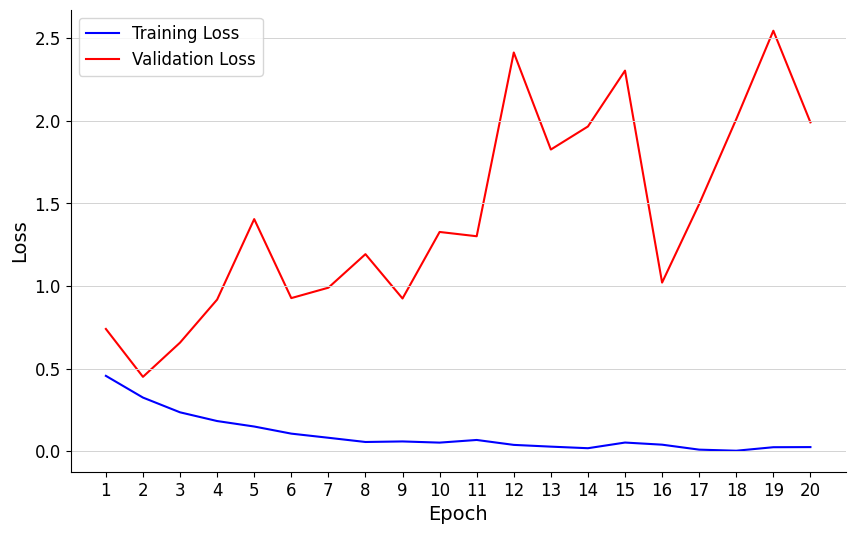

In [ ]:
N_EPOCHS = 20

train_losses = []
valid_losses = []
total_steps = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc, steps_in_epoch = train(classifier_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(classifier_model, valid_loader, criterion)
    total_steps += steps_in_epoch

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

classifier_model.cpu()
torch.save(classifier_model.state_dict(), SAVE_WEIGHTS_PATH)
print('Model weights saved')
print('Total steps: ', total_steps)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), train_losses, color='blue', label='Training Loss')
plt.plot(range(1, N_EPOCHS+1), valid_losses, color='red', label='Validation Loss')

plt.xticks(range(1, N_EPOCHS+1))
max_loss = max(max(train_losses), max(valid_losses))
max_val = round(max_loss + 0.5, 1)
if not LARGE_LSTM:
  yticks = [i for i in np.arange(0, max_val, 0.5)]
else:
  yticks = [i for i in np.arange(0, max_val, 0.25)]
plt.yticks(yticks)

for y in yticks:
    plt.axhline(y, color='lightgrey', linewidth=0.7)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper left', fontsize=12)

plt.savefig(SAVE_PLOT_IMG_PATH)
print('Plot of loss saved')
plt.show()